In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

import os
from helpers.datasets import *
from helpers.plotting import *
from sklearn.model_selection import train_test_split


plt.style.use("science.mplstyle")
cm = matplotlib.cm.get_cmap('Greens')
from matplotlib.backends.backend_pdf import PdfPages as pp

np.random.seed(8)

In [2]:
# directories
feta_dir = "/global/home/users/rrmastandrea/FETA/"

STS_config_string = f"LHCO_STS/"
STS_dir = os.path.join(feta_dir, STS_config_string, "data")
os.makedirs(STS_dir, exist_ok=True)

In [3]:
# dataset generation parameters
context_endpoints = (2500, 4500)


bands_dict = {"ob1": [2500, 2900],
              "sb1": [2900, 3300],
              "sr" : [3300, 3700],
              "sb2": [3700, 4100],
              "ob2": [4100, 4500]}


print("Generating datasets...")

bands_to_analyze = ["sb1", "sr", "sb2"]

df_sim = get_lhco(sim_type = "herwig")
data_sim = select_lhco_features(df_sim, feature_type = 0).to_numpy()

df_dat = get_lhco(sim_type = "pythia")
data_dat = select_lhco_features(df_dat, feature_type = 0).to_numpy()

df_signal = get_lhco(sim_type = "pythia", sm = "signal")
data_signal = select_lhco_features(df_signal, feature_type = 0).to_numpy()

# add an extra column to keep track of sig, bkg information
data_sim = np.hstack((data_sim, np.zeros((len(data_sim), 1))))
data_dat = np.hstack((data_dat, np.zeros((len(data_dat), 1))))
data_signal = np.hstack((data_signal, np.ones((len(data_signal), 1))))

print("SIM shape:", data_sim.shape)
print("DAT shape:", data_dat.shape)
print("SIGNAL shape:", data_signal.shape)

n_features = 6

Generating datasets...
events_anomalydetection_herwig_features.h5
events_anomalydetection_v2.features.h5
events_anomalydetection_v2.features.h5
SIM shape: (999986, 7)
DAT shape: (999881, 7)
SIGNAL shape: (99966, 7)


In [4]:
def pull_from_mass_range(dataset, mass_ranges):

        """
        mass_ranges is a list of lists [low_bound, high_bound]
        """

        selected_data = []

        for mass_range in mass_ranges:
            loc = np.where((dataset[:, 5] >= mass_range[0]) & (dataset[:, 5] < mass_range[1]))[0]
            selected_data.append( dataset[loc, :] )
        selected_data = np.concatenate(selected_data)
        np.random.shuffle(selected_data)

        return selected_data

def pull_n_signal_events(n, sig_dataset):
    
    selected_sig_indices = np.random.choice(sig_dataset.shape[0], size=n, replace=False)
    selected_sig_events = sig_dataset[selected_sig_indices]
    
    return(selected_sig_events)

## Count number of events ber band

In [5]:
herwig_bkg_dict = {}
pythia_bkg_dict = {}
pythia_sig_dict = {}

num_sig_events = {}

for b in bands_to_analyze:
    print(f"Number of events in band {b}:")
    loc = pull_from_mass_range(data_sim, [bands_dict[b]])
    herwig_bkg_dict[b] = loc
    print(f"Herwig bkg: {len(loc)}")
    loc = pull_from_mass_range(data_dat, [bands_dict[b]])
    pythia_bkg_dict[b] = loc
    print(f"Pythia bkg: {len(loc)}")
    loc = pull_from_mass_range(data_signal, [bands_dict[b]])
    pythia_sig_dict[b] = loc
    num_sig_events[b] = len(loc)
    print(f"Pythia sig: {len(loc)}")
          
    print()

num_total_sig_events = sum(list(num_sig_events.values()))

print(f"Total number of events: {num_total_sig_events}")

Number of events in band sb1:
Herwig bkg: 210767
Pythia bkg: 212115
Pythia sig: 11565

Number of events in band sr:
Herwig bkg: 121978
Pythia bkg: 121339
Pythia sig: 75299

Number of events in band sb2:
Herwig bkg: 68609
Pythia bkg: 66646
Pythia sig: 8842

Total number of events: 95706


## Pull from sb1 -> sb2 to visualize and get column rescales

[[1.6536600589752197, 882.2570190429688], [0.0, 1184.9076232910156], [0.009776264006552146, 0.9965418862980585], [0.01924640693824991, 0.9787161193778101], [2.120505396135613, 4.624545633786224], [2900.0004774390263, 4099.985995993352]]
SIM shape: (401354, 7)
DAT shape: (400100, 7)
SIGNAL shape: (95706, 7)


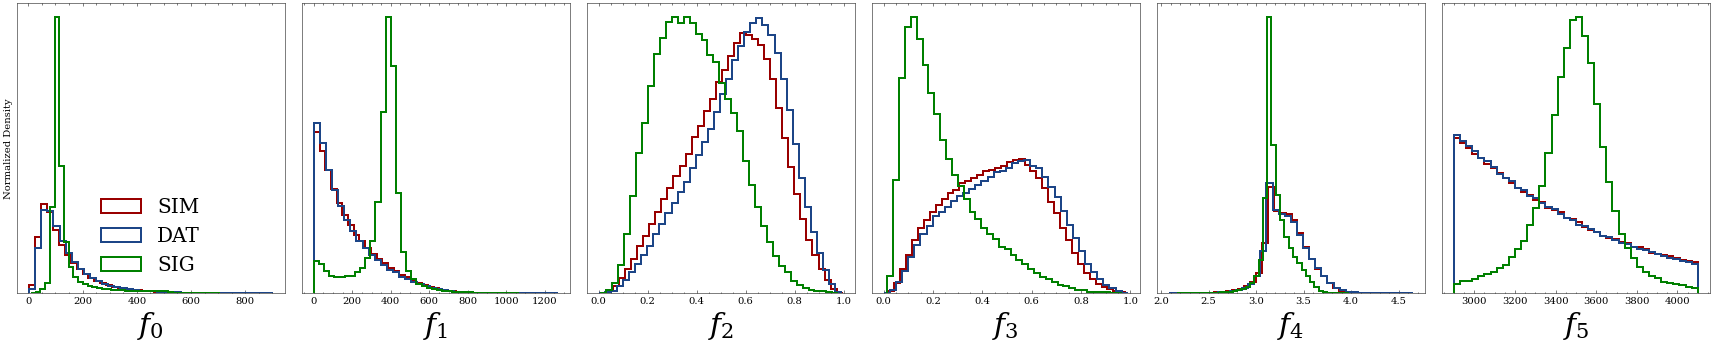

In [8]:
pulls = [bands_dict[b] for b in bands_to_analyze]

in_range_herwig_bkg = pull_from_mass_range(data_sim, pulls)
in_range_pythia_bkg = pull_from_mass_range(data_dat, pulls)
in_range_pythia_sig = pull_from_mass_range(data_signal, pulls)


# list of (min, max) to preprocess every column
col_minmax = []
for col in range(n_features):
    col_minmax.append([np.min(in_range_herwig_bkg[:, col]), np.max(in_range_herwig_bkg[:, col])])
    
print(col_minmax)

print("SIM shape:", in_range_herwig_bkg.shape)
print("DAT shape:", in_range_pythia_bkg.shape)
print("SIGNAL shape:", in_range_pythia_sig.shape)

feature_labels = [r"$f_0$", r"$f_1$", r"$f_2$", r"$f_3$", r"$f_4$", r"$f_5$"]

# Plot some features
fig = plot_feature_histograms(in_range_herwig_bkg, in_range_pythia_bkg, 40, n_features, feature_labels, 
                              third_plot = in_range_pythia_sig)
fig.show()



## Generate a standard test set and write out

This is the first 20k signal, 20k background events IN THE SR


(20000, 6) (20000, 6)
{'sb1': 11565, 'sr': 75299, 'sb2': 8842}


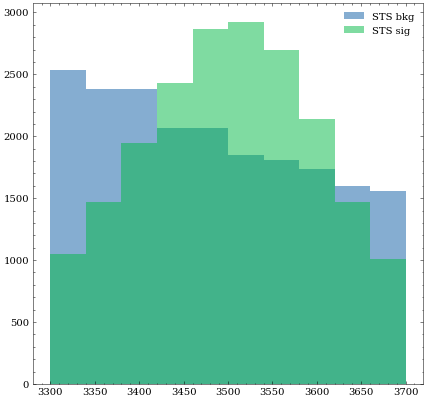

In [10]:
n_sts = 20000

sts_bkg = pythia_bkg_dict["sr"][:n_sts,:-1]
sts_sig = pythia_sig_dict["sr"][:n_sts,:-1]

print(sts_bkg.shape, sts_sig.shape)

print(num_sig_events)

plt.figure()
plt.hist(sts_bkg[:,-1], alpha = 0.5, label = "STS bkg")
plt.hist(sts_sig[:,-1], alpha = 0.5, label = "STS sig")
plt.legend()
plt.show()

In [11]:
np.save(os.path.join(STS_dir, "STS_bkg.npy"), sts_bkg)
np.save(os.path.join(STS_dir, "STS_sig.npy"), sts_sig)
np.save(os.path.join(STS_dir, "col_minmax.npy"), col_minmax)

## Generate the supervised dataset

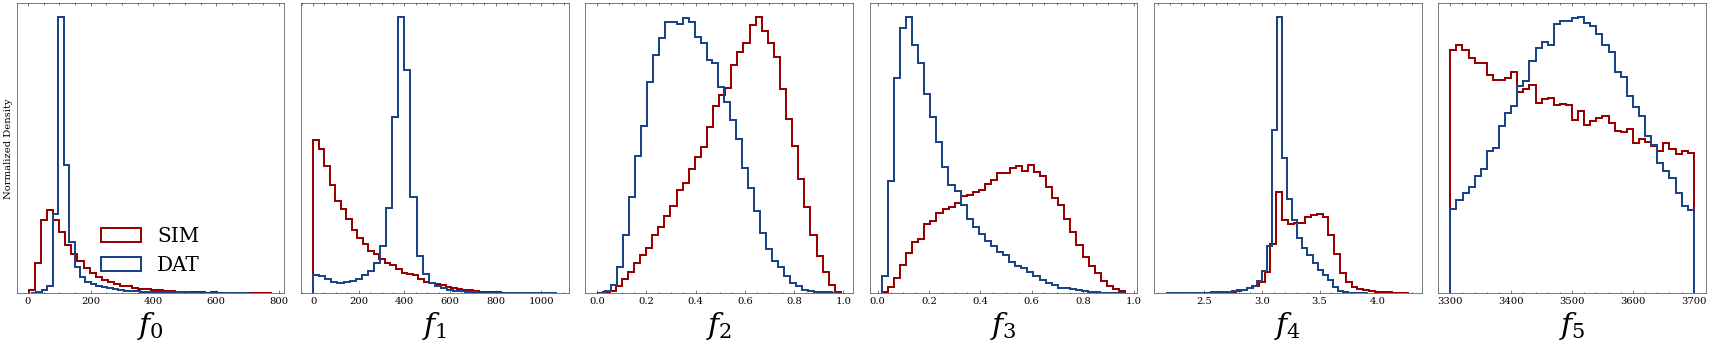

In [13]:
true_sup_bkg = pythia_bkg_dict["sr"][n_sts:75299,:-1]
true_sup_sig = pythia_sig_dict["sr"][n_sts:,:-1]

fig = plot_feature_histograms(true_sup_bkg, true_sup_sig, 40, n_features, feature_labels)
fig.show()

np.save(os.path.join(STS_dir, "true_sup_bkg.npy"), true_sup_bkg)
np.save(os.path.join(STS_dir, "true_sup_sig.npy"), true_sup_sig)

### Pull n signal events from the range (sb1 -> sb2)

In [16]:
num_signal_to_inject = 2500

# initialize the "data"
pythia_bkg_w_inj = in_range_pythia_bkg

# to get the ratios right: to inject nnum_signal_to_inject events:
    #for each band, inject num_signal_to_inject*num_sig_events[band]/num_total_sig_events
    
for b in bands_to_analyze:
    n_sig_band = int(num_signal_to_inject*num_sig_events[b]/num_total_sig_events)
    if b != "sr":
        selected_signal_band = pull_n_signal_events(n_sig_band, pythia_sig_dict[b])
    else: 
        selected_signal_band = pull_n_signal_events(n_sig_band, pythia_sig_dict[b][n_sts:])

    pythia_bkg_w_inj = np.concatenate((pythia_bkg_w_inj, selected_signal_band))
    print(f"Num events after injected in band {b}: {pythia_bkg_w_inj.shape}")
    print(f"Num signal events injected: {selected_signal_band.shape}")
    print()

np.random.shuffle(pythia_bkg_w_inj)

print(f"Pythia background, SB1 to SB2: {in_range_pythia_bkg.shape}")
print(f"Pythia background w/ injection, SB1 to SB2: {pythia_bkg_w_inj.shape}")


Num events after injected in band sb1: (400402, 7)
Num signal events injected: (302, 7)

Num events after injected in band sr: (402368, 7)
Num signal events injected: (1966, 7)

Num events after injected in band sb2: (402598, 7)
Num signal events injected: (230, 7)

Pythia background, SB1 to SB2: (400100, 7)
Pythia background w/ injection, SB1 to SB2: (402598, 7)


## Nice plots of the dataset

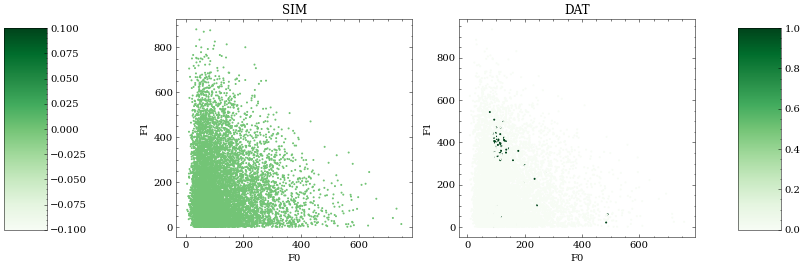

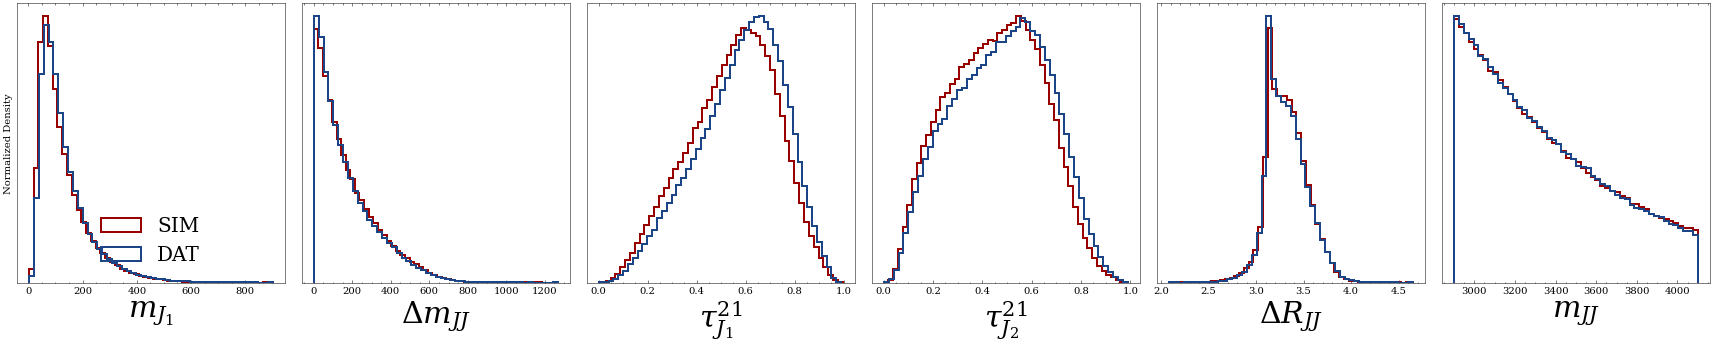

In [20]:
n_plot = 10000
bins = 50
dpi = 800

# Scatterplot the features
fig = scatterplot_features(in_range_herwig_bkg, pythia_bkg_w_inj, bins, n_features, feature_labels, n_plot = n_plot)
fig.show()


# 1D histograms
labels = ["$m_{J_1}$", "$\Delta m_{JJ}$", "$\\tau^{21}_{J_1}$", "$\\tau^{21}_{J_2}$", "$\Delta R_{JJ}$", "$m_{JJ}$"]


fig = plot_feature_histograms(in_range_herwig_bkg, pythia_bkg_w_inj, bins, n_features, labels)
fig.savefig(f"paper_plots/LHC_datasets.pdf", dpi = dpi)

fig.show()


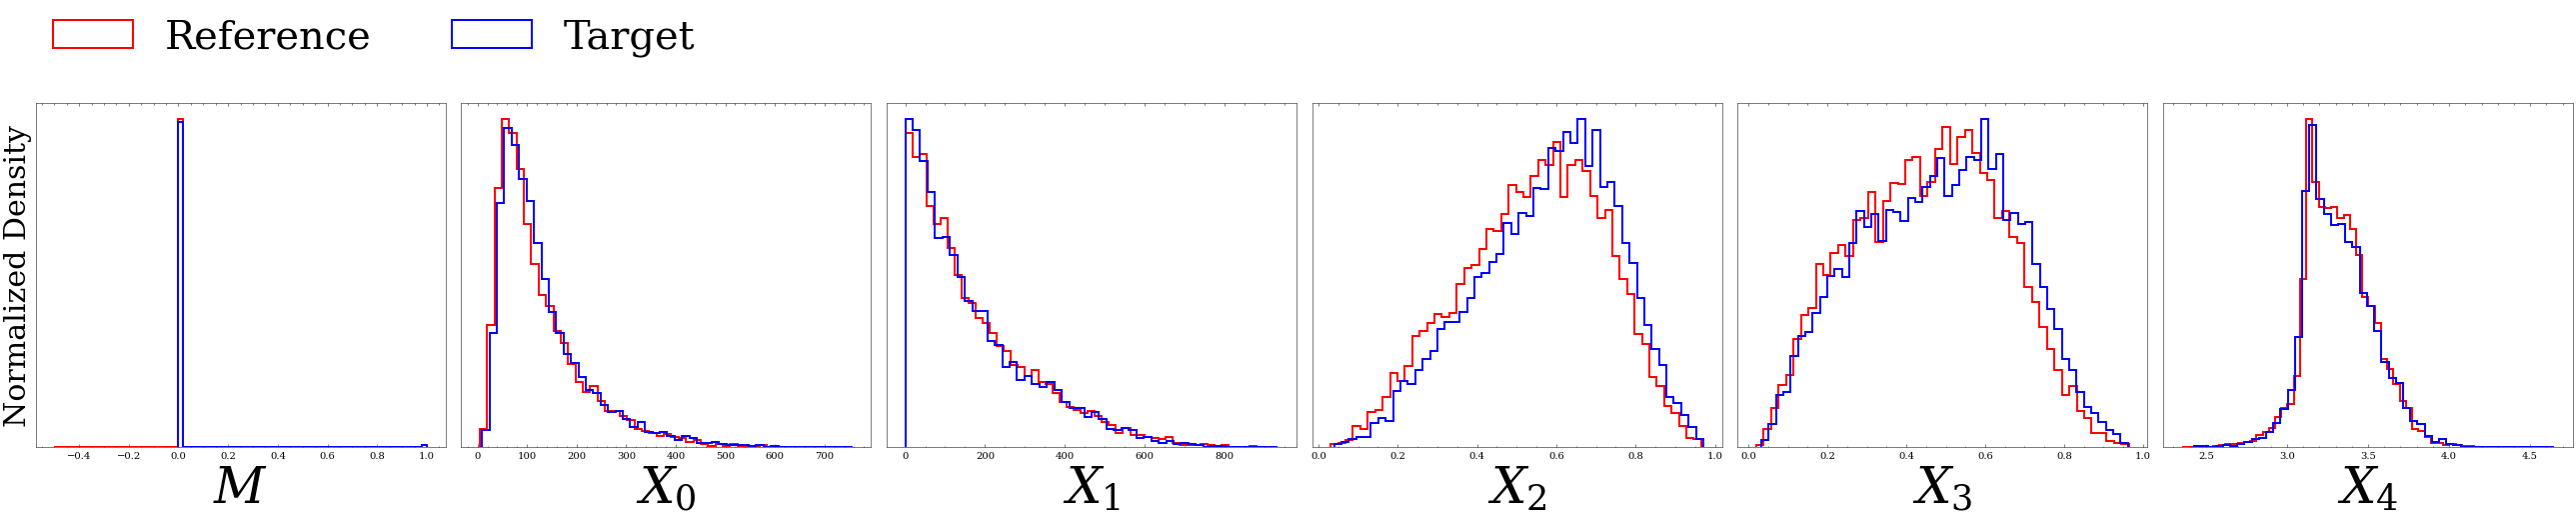

In [21]:
# NIPS plot
pp = PdfPages(os.path.join("paper_plots", f"LHC_datasets_NIPS.pdf"))


labels = ["l","$X_0$", "$X_1$", "$X_2$", "$X_3$", "$X_4$", "S"]
w = 2

fig, ax = plt.subplots(1, n_features, figsize = (6*n_features, 6))

r = ax[0].hist(in_range_herwig_bkg[:n_plot,-1], bins = bins, density = True, label = "Reference", histtype = "step", color = "red", linewidth = w)
t = ax[0].hist(pythia_bkg_w_inj[:n_plot,-1], bins = bins, density = True, label = "Target", histtype = "step", color = "blue", linewidth = w)
#ax[0].legend(fontsize = 30, ncol = 2, loc = (1, 1))
ax[0].set_xlabel("$M$", fontsize = 50)
ax[0].set_ylabel("Normalized Density", fontsize = 30)
ax[0].set_yticks([])

for i in range(1, n_features):
    ax[i].hist(in_range_herwig_bkg[:n_plot,(i-1)], bins = bins, density = True, label = "Reference", histtype = "step", color = "red", linewidth = w)
    ax[i].hist(pythia_bkg_w_inj[:n_plot,(i-1)], bins = bins, density = True, label = "Target", histtype = "step", color = "blue", linewidth = w)
    #ax[i].legend(fontsize = 24)
    ax[i].set_xlabel(labels[i], fontsize = 50)
    ax[i].set_yticks([])
    
plt.tight_layout()

fig.legend(["Reference", "Target"], loc='lower right', bbox_to_anchor=(.285, 1), ncol=len(labels), bbox_transform=fig.transFigure, fontsize = 40)

fig.show()
pp.savefig()
pp.close()

In [22]:
# save everything out

dataset_config_string = f"LHCO_{num_signal_to_inject}sig_f/"
data_dir = os.path.join(feta_dir, dataset_config_string, "data")

print("Making dataset directory at", data_dir, "...")
os.makedirs(data_dir, exist_ok=True)

# prepare the density estimation datasets
train_herwig = pull_from_mass_range(in_range_herwig_bkg, [bands_dict["sb1"], bands_dict["sr"], bands_dict["sb2"]])
sb1_sb2_pythia = pull_from_mass_range(pythia_bkg_w_inj, [bands_dict["sb1"], bands_dict["sb2"]])
print(train_herwig.shape,sb1_sb2_pythia.shape )
# split the data into train-val
sim_train, sim_val = train_test_split(train_herwig, test_size=0.2, random_state=42)
dat_train, dat_val = train_test_split(sb1_sb2_pythia, test_size=0.2, random_state=42)

np.save(os.path.join(data_dir, "train_sim.npy"), sim_train[:, :-1])
np.save(os.path.join(data_dir, "val_sim.npy"), sim_val[:, :-1])
np.save(os.path.join(data_dir, "train_dat.npy"), dat_train[:, :-1])
np.save(os.path.join(data_dir, "val_dat.npy"), dat_val[:, :-1])

# prepare the classifier traininf
sr_herwig = pull_from_mass_range(in_range_herwig_bkg, [bands_dict["sr"]])
sr_pythia = pull_from_mass_range(pythia_bkg_w_inj, [bands_dict["sr"]])
print(sr_herwig.shape,sr_pythia.shape )

np.save(os.path.join(data_dir, "classif_train_sim.npy"), sr_herwig[:, :-1])
np.save(os.path.join(data_dir, "classif_train_dat.npy"), sr_pythia[:, :-1])

Making dataset directory at /global/home/users/rrmastandrea/FETA/LHCO_2500sig_f/data ...
(401354, 7) (279293, 7)
(121978, 7) (123305, 7)


## Save out a training dataset for CATHODE

In [ ]:
def prep_set_for_cathode(dset):
    
    # rescale the non-mass features
    
    dset[:,:-2] = minmaxscale(dset[:,:-2], col_minmax[:-1], lower = 0, upper  = 1.0)
    
    cathode_dset = np.zeros(dset.shape)
    
    cathode_dset[:,0] = dset[:,5] / 1000. # divide mass by 1000
    cathode_dset[:,1] = dset[:,0]
    cathode_dset[:,2] = dset[:,1]
    cathode_dset[:,3] = dset[:,2]
    cathode_dset[:,4] = dset[:,3]
    cathode_dset[:,5] = dset[:,4]
    cathode_dset[:,6] = dset[:,6]

    
    return cathode_dset


cathode_SB_data_train = prep_set_for_cathode(dat_train)
cathode_SB_data_val = prep_set_for_cathode(dat_val)
cathode_SR_data = prep_set_for_cathode(sr_pythia)

n_val = 20
cathode_SR_data_train = cathode_SR_data[:-n_val]
cathode_SR_data_val = cathode_SR_data[-n_val:]


sts_bkg = pythia_bkg_dict["sr"][:n_sts]
sts_sig = pythia_sig_dict["sr"][:n_sts]

all_test_data = np.vstack((sts_bkg, sts_sig))
cathode_test_data = prep_set_for_cathode(all_test_data)

fig, ax = plt.subplots(1, 7, figsize = (4*6, 3))


for i in range(7):
    ax[i].hist(cathode_SB_data_train[:,i], bins = 40, density = True, label = "Train", histtype = "step", color = "red", linewidth = w)
    ax[i].hist(cathode_SB_data_val[:,i], bins = 40, density = True, label = "Val", histtype = "step", color = "blue", linewidth = w)
    ax[i].hist(cathode_SR_data_train[:,i], bins = 40, density = True, label = "Test", histtype = "step", color = "pink", linewidth = w)
    ax[i].hist(cathode_test_data[:,i], bins = 40, density = True, label = "Test", histtype = "step", color = "orange", linewidth = w)
    print(np.min(cathode_SB_data_train[:,i]), np.max(cathode_SB_data_train[:,i]))
        
    ax[i].set_yticks([])
    
plt.tight_layout()
plt.legend()


fig.show()


# save with labels for CATHODE
np.save(os.path.join(data_dir, "outerdata_train.npy"), cathode_SB_data_train)
np.save(os.path.join(data_dir, "outerdata_test.npy"), cathode_SB_data_val)

np.save(os.path.join(data_dir, "innerdata_train.npy"), cathode_SR_data_train)
np.save(os.path.join(data_dir, "innerdata_val.npy"), cathode_SR_data_val)
np.save(os.path.join(data_dir, "innerdata_test.npy"), cathode_test_data)


In [ ]:
# directories
curtains_dir = "/global/home/users/rrmastandrea/CURTAINS_SALAD/"

# function input paramters


dataset_config_string = f"LHCO_{num_signal_to_inject}sig_f_INJ_IN_SR_ONLY/"
data_dir = os.path.join(curtains_dir, dataset_config_string, "data")

print("Making dataset directory at", data_dir, "...")
os.makedirs(data_dir, exist_ok=True)

# prepare the density estimation datasets
sb1_sb2_herwig = pull_from_mass_range(in_range_herwig_bkg, [bands_dict["sb1"], bands_dict["sb2"]])
sb1_sb2_pythia = pull_from_mass_range(pythia_bkg_w_inj_SR_ONLY, [bands_dict["sb1"], bands_dict["sb2"]])
print(sb1_sb2_herwig.shape,sb1_sb2_pythia.shape )
# split the data into train-val
sim_train, sim_val = train_test_split(sb1_sb2_herwig, test_size=0.2, random_state=42)
dat_train, dat_val = train_test_split(sb1_sb2_pythia, test_size=0.2, random_state=42)


# save

np.save(os.path.join(data_dir, "train_sim.npy"), sim_train)
np.save(os.path.join(data_dir, "val_sim.npy"), sim_val)
np.save(os.path.join(data_dir, "train_dat.npy"), dat_train)
np.save(os.path.join(data_dir, "val_dat.npy"), dat_val)
np.save(os.path.join(data_dir, "col_minmax.npy"), col_minmax)
np.save(os.path.join(data_dir, "col_rescales.npy"), col_rescales)


# prepare the classifier traininf
sr_herwig = pull_from_mass_range(in_range_herwig_bkg, [bands_dict["sr"]])
sr_pythia = pull_from_mass_range(pythia_bkg_w_inj_SR_ONLY, [bands_dict["sr"]])
print(sr_herwig.shape,sr_pythia.shape )



np.save(os.path.join(data_dir, "classif_train_sim.npy"), sr_herwig)
np.save(os.path.join(data_dir, "classif_train_dat.npy"), sr_pythia)